## Zillow Sales versus List prices weekly for major US cities

In [1]:
# Loading in the basics
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

In [2]:
# Connect to postgres db
ENDPOINT="ucb-data-group-project-zillow.csaw135fqqkl.us-west-1.rds.amazonaws.com"
PORT="5432"
USR="postgres"
REGION="us-west-1"


In [3]:
DBNAME="postgres"

conn = psycopg2.connect(database = DBNAME,
                        user =     USR,
                        password = "aldavidethanjohn",
                        host =     ENDPOINT,
                        port =     PORT)

In [4]:
# list table sql
list_sql = '''
            SELECT *
            FROM list;
            '''

In [5]:
# sale table sql
sale_sql = '''
            SELECT *
            FROM sale;
            '''

In [6]:
# setting up dfs
list_df = pd.read_sql(list_sql, conn)
sale_df = pd.read_sql(sale_sql, conn)

In [7]:
# inspect list df
list_df.head()

,region_date,region_id,size_rank,region_name,region_type,state_name,date,price
0,10200120171104,102001,0,United States,Country,None,2017-11-04,275448.0
1,39491320171104,394913,1,"New York, NY",Msa,NY,2017-11-04,526850.0
2,75389920171104,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,2017-11-04,812252.0
3,39446320171104,394463,3,"Chicago, IL",Msa,IL,2017-11-04,319556.0
4,39451420171104,394514,4,"Dallas-Fort Worth, TX",Msa,TX,2017-11-04,347537.0


In [8]:
# inspect sale df
sale_df.head()

,region_date,region_id,size_rank,region_name,region_type,state_name,date,price
0,10200120080223,102001,0,United States,Country,None,2008-02-23,191138.0
1,39491320080223,394913,1,"New York, NY",Msa,NY,2008-02-23,NaN
2,75389920080223,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,2008-02-23,516750.0
3,39446320080223,394463,3,"Chicago, IL",Msa,IL,2008-02-23,247988.0
4,39451420080223,394514,4,"Dallas-Fort Worth, TX",Msa,TX,2008-02-23,143466.0


In [9]:
# general cleaning
sale_df = sale_df.drop(["region_date","region_id","region_type"],1)
list_df = list_df.drop(["region_date","region_id", "region_type"],1)
list_df.head()

,size_rank,region_name,state_name,date,price
0,0,United States,None,2017-11-04,275448.0
1,1,"New York, NY",NY,2017-11-04,526850.0
2,2,"Los Angeles-Long Beach-Anaheim, CA",CA,2017-11-04,812252.0
3,3,"Chicago, IL",IL,2017-11-04,319556.0
4,4,"Dallas-Fort Worth, TX",TX,2017-11-04,347537.0


In [10]:
# us data pullout for list and sales data

us_list = list_df.loc[list_df["region_name"] == "United States"]
us_list = us_list.drop(["size_rank", "state_name"], 1)
us_sale = sale_df.loc[sale_df["region_name"] == "United States"]
us_sale = us_sale.drop(["size_rank", "state_name"],1)

us_sale.head()

,region_name,date,price
0,United States,2008-02-23,191138.0
128,United States,2020-10-31,290550.0
199,United States,2008-03-01,192225.0
296,United States,2008-03-08,192225.0
393,United States,2008-03-15,192475.0


In [22]:
# prepping us dfs for merge and merging
us_list = us_list.rename(columns = {"price":"list price"})
us_sale = us_sale.rename(columns = {"price":"sale price"})

us_df = us_list.merge(us_sale, on = ["region_name","date"], how = "right")
us_df = us_df.dropna()

us_df["date"] = pd.to_datetime(us_df["date"])
us_df = us_df.set_index(["date"]).sort_index()
us_df.head()

,region_name,list price,sale price
date,,,
2017-11-04,United States,275448.0,235099.0
2017-11-11,United States,275448.0,234750.0
2017-11-18,United States,275448.0,235750.0
2017-11-25,United States,274975.0,235916.0
2017-12-02,United States,274825.0,237166.0


<AxesSubplot:xlabel='date'>

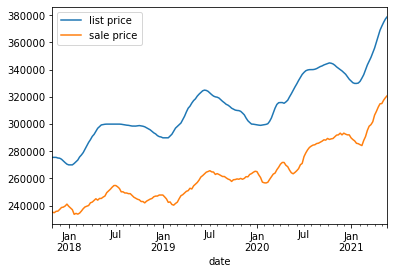

In [24]:
# examining the relation between list and sale
us_df.plot()

In [25]:
us_df["list/sale %"] = (us_df["sale price"] / us_df["list price"]) * 100
us_df["list/sale actual"] = (us_df["list price"] - us_df["sale price"])
us_df.head()


,region_name,list price,sale price,list/sale %,list/sale actual
date,,,,,
2017-11-04,United States,275448.0,235099.0,85.351500,40349.0
2017-11-11,United States,275448.0,234750.0,85.224797,40698.0
2017-11-18,United States,275448.0,235750.0,85.587842,39698.0
2017-11-25,United States,274975.0,235916.0,85.795436,39059.0
2017-12-02,United States,274825.0,237166.0,86.297098,37659.0


<AxesSubplot:xlabel='date'>

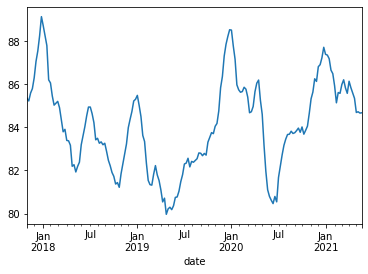

In [28]:
percent_difference = us_df["list/sale %"]
us_df = us_df.drop(["list/sale %"], axis =1)
percent_difference.plot()

<AxesSubplot:xlabel='date'>

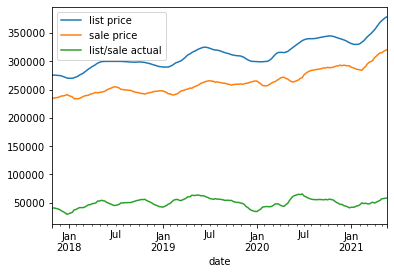

In [30]:
us_df.plot()

In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten,LSTM,RepeatVector,TimeDistributed,Conv1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from livelossplot.keras import PlotLossesCallback

from statsmodels.tsa.seasonal import seasonal_decompose

In [32]:
df = us_df
df = df.rename(columns = {"list price": "x"})
df = df.rename(columns = {"sale price": "y"})


In [33]:
def train_test_builder(df,size_test=24,length_train_sequence = 24,length_forecast = 12, normalize = False):
    
    train_df = df[:-size_test]    
    
    # create training sets
    train_x,train_y = window_splitter(train_df)
    
    # create test set
    tmp = df[:length_forecast]
    tmp = pd.concat([df,tmp],ignore_index = True)
    tmp[-length_forecast:] = np.nan  # unknown
    test_x,test_y = window_splitter(tmp)
    # drop elements in training
    test_x = test_x[train_x.shape[0]:]
    test_y = test_y[train_x.shape[0]:]
    for i in range(length_forecast):
        test_y[i,:(11-i)]=np.nan # present in training_set
    
    # normalize
    if normalize:
        m = train_df.x.mean()
        sd = train_df.x.std()
        train_x -= m
        train_x/= sd
        test_x -=m
        test_x /= sd
    
    return train_x,train_y,test_x,test_y


# iterate over the time steps and divide the data into overlapping windows; 
def window_splitter(train_df,length_train_sequence = 24,length_forecast = 12):
    i = 0
    x,y = [],[]
    while i + length_train_sequence+ length_forecast < len(train_df):
        x.append(train_df.x[i:(i+length_train_sequence)].values)
        y.append(train_df.x[(i+length_train_sequence):(i+length_train_sequence+length_forecast)].values)
        i+=1

    x = np.array(x).reshape(-1,length_train_sequence,1)
    y = np.array(y).reshape(-1,length_forecast)
    
    return x,y

<ipython-input-34-25f850fd96ff>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(series, model='additive',freq=12,two_sided = False,)


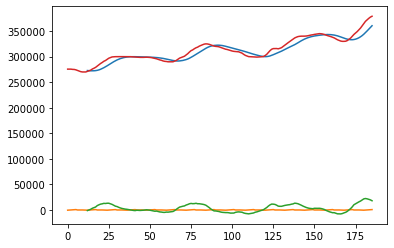

In [34]:
# a naive seasonal decomposition
series = df.x.values
result = seasonal_decompose(series, model='additive',freq=12,two_sided = False,)
plt.plot(result.trend)
plt.plot(result.seasonal)
plt.plot(result.resid)
plt.plot(result.observed)

In [36]:
train_x,train_y,test_x,test_y = train_test_builder(df)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((126, 24, 1), (126, 12), (36, 24, 1), (36, 12))

In [37]:

# evaluation function
def evaluate_predictions(pred_y, test_y):
    return pd.DataFrame(abs(test_y-pred_y)).mean(skipna = True)


def plot_evaluation(pred_y,test_y,n=12):
    scores = evaluate_predictions(pred_y,test_y)

    print("Mean absolute error test set:",scores.mean())

    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1,13),scores)
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.ylabel("MAE", size = 15)
    plt.title("Scores LSTM on test set")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.title("LSTM forecasting - test set window")
    plt.plot(np.arange(1,13),pred_y[n:(n+1)].reshape(-1,1),label = "predictions")
    plt.plot(np.arange(1,13),test_y[n:(n+1)].reshape(-1,1),label = "true values")
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.legend()
    plt.show()

In [38]:

n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(None, 1)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs))

# compile
model.compile(loss='mse', optimizer= Adam(lr=1e-3), metrics = ["mae"])

# callbacks
early_stopping = EarlyStopping(patience=32, monitor='val_loss', mode='auto', restore_best_weights=True)
callbacks=[PlotLossesCallback(), early_stopping]

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
series = us_df.x.values
result = seasonal_decompose(series, model='additive',freq=12,two_sided = False,)
plt.plot(result.trend)
plt.plot(result.seasonal)
plt.plot(result.resid)
plt.plot(result.observed)


In [ ]:
# node count: ???
# activation method: swish
# gist per austin: 100~200, nodes: play with, hidden layers: 1~2 max 3